In [14]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import numpy as np
import cv2
import time
import sys
import re
from copy import deepcopy
from collections import defaultdict
from itertools import islice
from tqdm import tqdm_notebook
from time import time
from easydict import EasyDict
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from warnings import filterwarnings

from mvn.datasets.human36m import Human36MMultiViewDataset, Human36MTemporalDataset
from train import setup_human36m_dataloaders

import torch
from torch import nn
from torch.utils.data import DataLoader
from mvn.utils.img import image_batch_to_numpy, denormalize_image,to_numpy, \
                          get_square_bbox, resize_image, crop_image, normalize_image, scale_bbox

from mvn.utils.misc import get_start_stop_frame_indxs, index_to_name, get_error_diffs, normalize_temporal_images_batch, retval
from torch.utils.data import Dataset
from mvn.utils.multiview import Camera, project_3d_points_to_image_plane_without_distortion
from mvn.utils import volumetric
from mvn.utils.vis import draw_2d_pose
from mvn.utils import op
from mvn.utils import multiview
from mvn.utils import cfg
from mvn.datasets import utils as dataset_utils
%matplotlib inline

retval = {
    'subject_names': ['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11'],
    'camera_names': ['54138969', '55011271', '58860488', '60457274'],
    'action_names': [
        'Directions-1', 'Directions-2',
        'Discussion-1', 'Discussion-2',
        'Eating-1', 'Eating-2',
        'Greeting-1', 'Greeting-2',
        'Phoning-1', 'Phoning-2',
        'Posing-1', 'Posing-2',
        'Purchases-1', 'Purchases-2',
        'Sitting-1', 'Sitting-2',
        'SittingDown-1', 'SittingDown-2',
        'Smoking-1', 'Smoking-2',
        'TakingPhoto-1', 'TakingPhoto-2',
        'Waiting-1', 'Waiting-2',
        'Walking-1', 'Walking-2',
        'WalkingDog-1', 'WalkingDog-2',
        'WalkingTogether-1', 'WalkingTogether-2']
}

JOINT_H36_DICT = {0:'RFoot',
                 1:'RKnee',
                 2:'RHip',
                 3:'LHip',
                 4:'LKnee',
                 5:'LFoot',
                 6:'Hip',
                 7:'Spine',
                 8:'Thorax',
                 9:'Head',
                 10:'RWrist',
                 11:'RElbow',
                 12:'RShoulder',
                 13:'LShoulder',
                 14:'LElbow',
                 15:'LWrist',
                 16:'Neck/Nose'}

CONNECTIVITY_DICT = {
    'cmu': [(0, 2), (0, 9), (1, 0), (1, 17), (2, 12), (3, 0), (4, 3), (5, 4), (6, 2), (7, 6), (8, 7), (9, 10), (10, 11), (12, 13), (13, 14), (15, 1), (16, 15), (17, 18)],
    'coco': [(0, 1), (0, 2), (1, 3), (2, 4), (5, 7), (7, 9), (6, 8), (8, 10), (11, 13), (13, 15), (12, 14), (14, 16), (5, 6), (5, 11), (6, 12), (11, 12)],
    "mpii": [(0, 1), (1, 2), (2, 6), (5, 4), (4, 3), (3, 6), (6, 7), (7, 8), (8, 9), (8, 12), (8, 13), (10, 11), (11, 12), (13, 14), (14, 15)],
    "human36m": [(0, 1), (1, 2), (2, 6), (5, 4), (4, 3), (3, 6), (6, 7), (7, 8), (8, 16), (9, 16), (8, 12), (11, 12), (10, 11), (8, 13), (13, 14), (14, 15)],
    "kth": [(0, 1), (1, 2), (5, 4), (4, 3), (6, 7), (7, 8), (11, 10), (10, 9), (2, 3), (3, 9), (2, 8), (9, 12), (8, 12), (12, 13)],
}

device = 'cuda:0'

# Multiview

In [2]:
experiment_type = 'resnet_50/adain_1d'
experiment_name = 'h36_sv32_dist_adain-all-gn_s2v-lstm-1024-1024-1024-gn_vf32_f2v-backbone-C4-1024-group_resnet50-gn-nostylegrad_dt-12_dil-3-1-1_lr-1e-4@12.03.2020-19:00:21'     

experiment_root = os.path.join('../logs/', experiment_type, experiment_name)
config_path = experiment_root + '/config.yaml'

config = cfg.load_config(config_path)

train_loader, val_loader, _ = setup_human36m_dataloaders(config,
                                             is_train=True,
                                             distributed_train=False)

batch_size, dt, dilation = val_loader.batch_size, val_loader.dataset.dt, val_loader.dataset.dilation

pivot_type = config.dataset.pivot_type 
keypoints_per_frame = config.dataset.val.keypoints_per_frame if hasattr(config.dataset.val, 'keypoints_per_frame') else False
pivot_position = {'first':-1, 'intermediate':dt//2}[pivot_type]

if not hasattr(config.model.backbone, 'group_norm'):
    config.model.backbone.group_norm = False

print('Batch size:', batch_size, '\n',\
      'dt:', dt, '\n',\
      'dilation:', dilation, '\n',\
      'pivot_type:', pivot_type, '\n',\
      'pivot_position:', pivot_position,'\n',\
      'keypoints_per_frame', keypoints_per_frame)


Batch size: 1 
 dt: 12 
 dilation: 3 
 pivot_type: first 
 pivot_position: -1 
 keypoints_per_frame False


In [3]:
val_dataset = val_loader.dataset
train_dataset = train_loader.dataset

# Visualize output

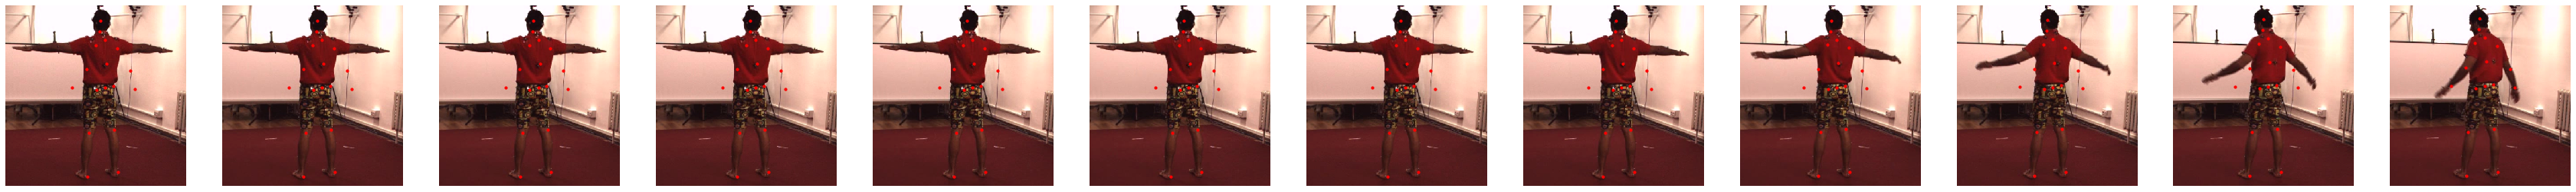

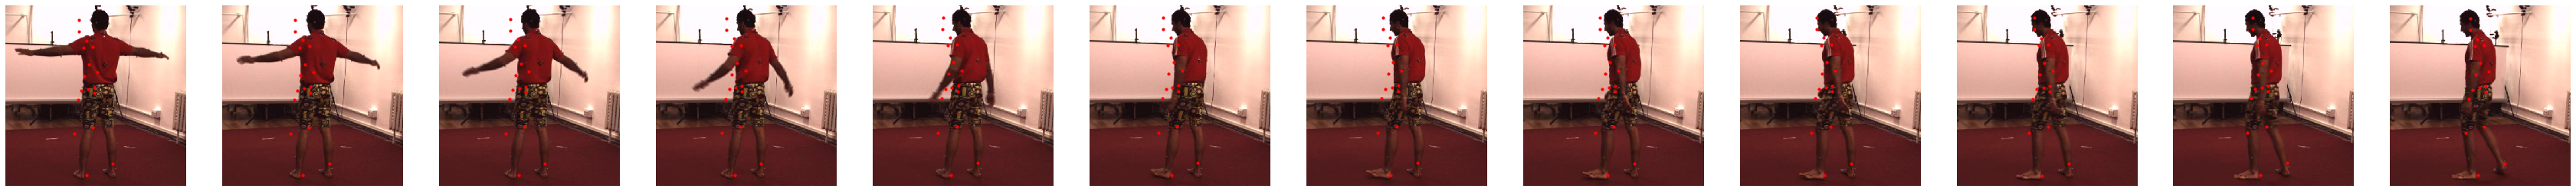

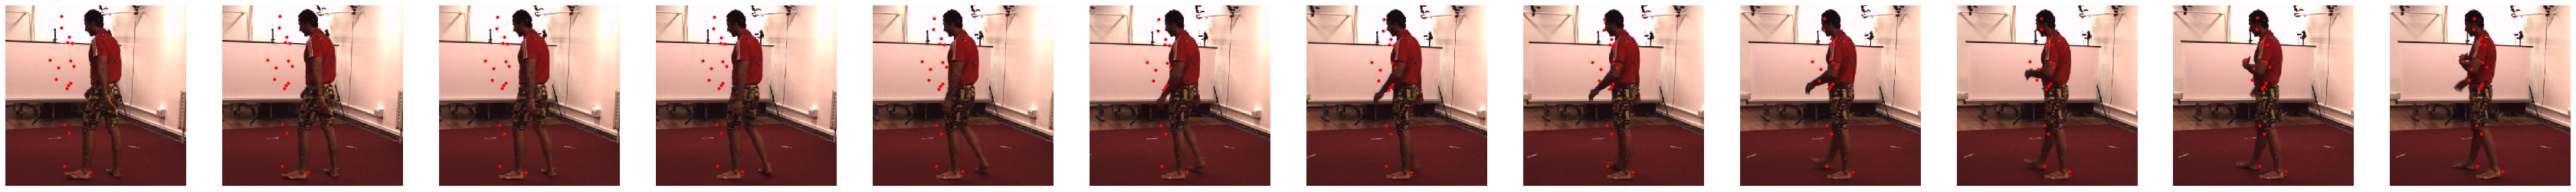

In [6]:
for batch in islice(val_loader, 3):

    n_views = batch['images'].shape[1]
    batch_size = batch['images'].shape[0]
    
    fig, axes = plt.subplots(ncols=n_views, nrows=1, figsize=(5 * n_views, 5))
    for i in range(n_views):
        # first row
        detection = batch['detections'][0][i]
        *bbox, c = detection
        
        image = batch['images'][0][i]
        image = denormalize_image(image).astype(np.uint8)
        image = image[..., ::-1]  # bgr -> rgb
        camera_name = batch['cameras'][i][0].name
        title = "{}, detection conf: {:.3}".format(camera_name, c)
        
        # second row
        keypoints_3d = batch['keypoints_3d'][0][:, :3]
        proj_matrix = batch['cameras'][i][0].projection
#         image_shape_before_resize = batch['image_shapes_before_resize'][0][i]
        image_shape = image.shape[:2]

        keypoints_2d_wrt_new = multiview.project_3d_points_to_image_plane_without_distortion(proj_matrix, keypoints_3d)
#         keypoints_2d_wrt_orig = transform_points_after_crop_and_resize(keypoints_2d_wrt_new, (bbox[0], bbox[1]), image_shape_before_resize, image_shape, forward=True)
        
        axes[i].set_xlim(0, image.shape[1])
        axes[i].set_ylim(0, image.shape[0])
        axes[i].invert_yaxis()
        axes[i].imshow(image)
        axes[i].scatter(keypoints_2d_wrt_new[:, 0], keypoints_2d_wrt_new[:, 1], s=10, c='red')
        
        axes[i].axis('off')
    plt.show()

In [22]:
labels=val_loader.dataset.labels
start_frame_indexes, stop_frame_indxs=get_start_stop_frame_indxs(labels)

# CMU

In [4]:
import os
import json
from collections import defaultdict
from copy import deepcopy
import pickle
import numpy as np
import cv2
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from mvn.utils.multiview import Camera
from mvn.utils.img import get_square_bbox, scale_bbox, resize_image, crop_image, image_batch_to_torch, normalize_image
from mvn.utils import volumetric
from IPython.core.debugger import set_trace

class CMUMultipleSceneDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.cumsum = [0] + list(np.cumsum([len(dataset) for dataset in self.datasets]))

    def __len__(self):
        return sum(len(dataset) for dataset in self.datasets)

    def __getitem__(self, idx):
        dataset_i = np.digitize(idx, self.cumsum) - 1
        return self.datasets[dataset_i].__getitem__(idx - self.cumsum[dataset_i], global_idx=idx)

    def evaluate(self, results):
        scalar_metric = 0.0
        full_metric = {}
        return scalar_metric, full_metric


class CMUTemporalDataset(Dataset):
    """Dataset for single CMU scene focused on multiview tasks

    Note: 1) __getitem__ method can return None, which means that requested
          index is not available (e.g. no person in the image). PyTorch native
          DataLoader doesn't support such behavior, so use safe
          dataset and dataloader from library 'nonechunks'
          (https://github.com/msamogh/nonechucks) which handles None elements.

          2) In DataLoader use custom collate_fn implemented as
          static method of this class
    """
    def __init__(self,
                 root,
                 dt,
                 dilation,
                 dilation_type,
                 keypoints_per_frame,
                 pivot_type,
                 image_shape=(256, 256),
                 kind='cmu',
                 ignore_list=[],
                 norm_image=True,
                 detection_conf_threshold=0.01,
                 scale_bbox=1.0,
                 frame_first=0,
                 frame_last=None,
                 skip_every_n_frames=1,
                 cuboid_side=200.0,
                 detector="ssd",
                 filter_keypoints_3d=False,
                 return_images=True,
                 crop_and_resize=False
                 ):
        self.root = os.path.normpath(root)
        self.scene_name = os.path.basename(self.root)
        print ('Scene_name:', self.scene_name)
        
        self.image_shape = tuple(image_shape)
        self.kind = kind
        self.norm_image = norm_image
        self.detection_conf_threshold = detection_conf_threshold
        self.detector = detector
        self.scale_bbox = scale_bbox
        self.filter_keypoints_3d = filter_keypoints_3d
        
        # how much there are consecutive frames in the sequence
        self.dt = dt
        # time dilation between frames
        self.dilation = dilation
        self.dilation_type = dilation_type
        self.keypoints_per_frame=keypoints_per_frame
        self.pivot_type = pivot_type

        self.frame_first = frame_first
        self.frame_last = frame_last
        self.skip_every_n_frames = skip_every_n_frames

        self.cuboid_side = cuboid_side

        self.return_images = return_images
        self.crop_and_resize = crop_and_resize

        self.ignore_list = ignore_list
        
        self.load_camera_names()
        self.load_cameras()
        self.load_image_dirs()
        self.check_consistency()
        
        if self.crop_and_resize:
            self.load_detections()
        if self.filter_keypoints_3d:
            self.load_sample_list()

        if self.frame_last is None:
            total_n_frames = len(os.listdir(self.image_dirs[self.camera_names[0]]))
            self.frame_last = total_n_frames - 1

        if self.pivot_type == 'intermediate':
            assert self.dt==0 or self.dt//2 != 0, 'Only odd `dt` is supported for intermediate pivot!'

        # Initially, consider all frames as pivots
        pivot_mask = np.ones((n_frames,),dtype=np.bool)
        # the whole time period covered, with dilation
        if self.dilation_type == 'exponential':
            self._time_period = np.exp(self.dilation+self.dt-2) + 1
        elif self.dilation_type == 'constant':
            self._time_period = self.dt + (self.dt-1)*(self.dilation)
        elif self.dilation_type == 'square':
            self._time_period = (self.dilation+self.dt-2)**2 + 1
            
        else:
            raise RuntimeError('Wrong dilation_type') 

        if self.dt != 0:
            frame_idx =  self.labels['table']['frame_idx']
            
            # Mark positions where the new scene or action is starting
            change_mask = np.concatenate((frame_idx[:-1] > frame_idx[1:], [False]))

            if self.pivot_type == 'intermediate':
                # Shift that positions shuch that all non-pivot positions marked `True`
                for _ in range((self._time_period//2)-1):
                    change_mask[:-1] = change_mask[:-1] | change_mask[1:]
                for _ in range(self._time_period//2):
                    change_mask[1:] = change_mask[1:] | change_mask[:-1]
                change_mask[:self._time_period//2] = True
                change_mask[-(self._time_period//2):] = True

            elif self.pivot_type == 'first':
                # Shift that positions shuch that all non-pivot positions marked `True`
                for _ in range(self._time_period-1):
                    change_mask[1:] = change_mask[1:] | change_mask[:-1]
                change_mask[:self._time_period-1] = True
            else:
                raise RuntimeError('Unknown `pivot_type` in config.dataset.<train/val>')   


            pivot_mask = ~change_mask

        self.pivot_mask = pivot_mask
        self.pivot_indxs = np.arange(n_frames)[pivot_mask][::retain_every_n_frames_in_test]
        self.n_sequences = len(self.pivot_indxs)

    def load_camera_names(self):
        self.camera_names = os.listdir(os.path.join(self.root, "hdImgs"))
        self.camera_names = list(filter(lambda x: x not in self.ignore_list, self.camera_names))
        self.camera_names = sorted(self.camera_names)

    def load_cameras(self):
        calibration_path = os.path.join(self.root, "calibration_{}.json".format(self.scene_name))
        with open(calibration_path) as fin:
            calibration_dict = json.load(fin)

        # camera params
        self.cameras = dict()
        for camera_rec in calibration_dict['cameras']:
            if camera_rec['name'] in self.camera_names:
                R = np.array(camera_rec['R'])
                t = np.array(camera_rec['t'])
                K = np.array(camera_rec['K'])
                dist = np.array(camera_rec['distCoef'])

                camera = Camera(R, t, K, dist, camera_rec['name'])
                self.cameras[camera_rec['name']] = camera

    def load_image_dirs(self):
        self.image_dirs = dict()
        camera_names_to_remove = []
        for camera_name in self.camera_names:
            image_dir = os.path.join(self.root, "hdImgs", camera_name)
            self.image_dirs[camera_name] = image_dir

    def load_detections(self):
        detections_dir = os.path.join(self.root, "{}-detections".format(self.detector))
        self.detections = dict()
        for camera_name in self.camera_names:
            with open(os.path.join(detections_dir, "{}.json".format(camera_name))) as fin:
                self.detections[camera_name] = json.load(fin)

    def check_consistency(self):
        # set of cameras cameras
        assert set(self.image_dirs.keys()) == set(self.cameras.keys()), \
        "Different set of cameras in self.image_dirs and self.cameras"

        # check quantity of video frames
        length_set = set()
        for image_dir in self.image_dirs.values():
            length = len(os.listdir(image_dir))
            length_set.add(length)

        assert len(length_set) == 1, \
        "Number of frames for different videos are not equal"

    def load_keypoints_3d(self, idx):
        hd_pose_json_path = os.path.join(self.root, "hdPose3d_stage1_coco19")
        hd_face_json_path = os.path.join(self.root, "hdFace3d")
        hd_hand_json_path = os.path.join(self.root, "hdHand3d")

        keypoints_3d = []

        # pose
        try:
            hd_pose_path = os.path.join(hd_pose_json_path, "body3DScene_{0:08d}.json".format(idx))
            with open(hd_pose_path) as fin:
                hd_pose = json.load(fin)

            keypoints_3d_pose = np.array(hd_pose['bodies'][0]['joints19']).reshape((-1, 4))
        except (FileNotFoundError, IndexError):
            keypoints_3d_pose = np.zeros((19, 4))

        if self.filter_keypoints_3d:
            if ('hd', "{0:08d}".format(idx)) not in self.sample_list[self.scene_name]:
                keypoints_3d_pose = np.zeros((19, 4))

        keypoints_3d.append(keypoints_3d_pose)
        return np.vstack(keypoints_3d)

    def load_sample_list(self):
        path = os.path.join(self.root, "..", "sample_list.pkl")
        with open(path, 'rb') as fin:
            self.sample_list = pickle.load(fin)

    def __len__(self):
        return len(self.pivot_indexes)

    def __getitem__(self, idx, global_idx=None):
        idx = self.frame_first + idx * self.skip_every_n_frames
        
        # temporal part
        camera_name, image_name = self.pivot_indexes[idx]

        sample = defaultdict(list)

        for camera_name in self.camera_names:
            if self.return_images:
                image_name = camera_name + '_' + "{:08}.jpg".format(idx)
                image_path = os.path.join(self.image_dirs[camera_name], image_name)

                # load image
                image = cv2.imread(image_path)
                
            camera = deepcopy(self.cameras[camera_name])
            if self.return_images:
                if self.crop_and_resize:
                    # load detection
                    try:
                        detection = self.detections[camera_name][idx]
                    except IndexError:
                        print("Failed to take detection: idx={}, root={}".format(idx, self.root))

                    *bbox, c = detection
                    if c < self.detection_conf_threshold:
                        continue  # don't account this image

                    bbox = tuple(map(int, bbox))
                    
                    # crop and resize image
                    bbox = get_square_bbox(bbox)
                    bbox = scale_bbox(bbox, self.scale_bbox)

                    image = crop_image(image, bbox)
                    image_shape_before_resize = image.shape[:2]

                    image = resize_image(image, self.image_shape)

                    # update camera parameters because of crop and resize
                    camera.update_after_crop(bbox)
                    camera.update_after_resize(image_shape_before_resize, image.shape[:2])
                    sample['detections'].append(bbox + (c,))

                if self.norm_image:
                    image = normalize_image(image)
                    
                sample['images'].append(image)
                
            sample['cameras'].append(camera)

        # 3D keypoints
        keypoints_3d = self.load_keypoints_3d(idx)[:19]  # NOTE: for now return only body
        if self.kind == 'coco':
            keypoints_3d = cmu_to_coco(keypoints_3d)
        sample['keypoints_3d'] = keypoints_3d

        # build cuboid
        if self.kind == 'coco':
            base_point = (keypoints_3d[11, :3] + keypoints_3d[12, :3]) / 2
        elif self.kind == 'cmu':
            base_point = keypoints_3d[2, :3]

        sides = np.array([self.cuboid_side, self.cuboid_side, self.cuboid_side])
        position = base_point - sides / 2
        sample['cuboids'] = volumetric.Cuboid3D(position, sides)

#         sample['pred_keypoints_3d'] = self.tri_pred[global_idx]
        sample['pred_keypoints_3d'] = sample['keypoints_3d'][:, :3]

        # print(global_idx)
        # print("diff", np.mean(np.abs(sample['pred_keypoints_3d'][11, :] - sample['keypoints_3d'][11, :3])))
        # print(sample['pred_keypoints_3d'][11, :], sample['keypoints_3d'][11, :3])
        sample['indexes'] = global_idx

        return sample

def cmu_to_coco(points):
    CMU_TO_COCO_MAP = [1, 15, 17, 16, 18, 3, 9, 4, 10, 5, 11, 6, 12, 7, 13, 8, 14]
    return points[CMU_TO_COCO_MAP]

def openpose_to_coco(points):
    OPENPOSE_TO_COCO_MAP = [0, 16, 15, 18, 17, 5, 2, 6, 3, 7, 4, 12, 9, 13, 10, 14, 11]
    return points[OPENPOSE_TO_COCO_MAP]


In [60]:
# '00_00_00024196.jpg'
# camera + '_' + "{:08}.jpg".format(0)

In [61]:

dataset = CMUSceneDataset(root='/media/hpc3_storage/ibulygin/panoptic-toolbox/171026_pose1/',
                            image_shape=(256, 256),
                            kind='cmu',
                            ignore_list=[],
                            norm_image=True,
                            detection_conf_threshold=None,
                            scale_bbox=None,
                            frame_first=0,
                            frame_last=None,
                            skip_every_n_frames=1,
                            cuboid_side=200.0,
                            detector=None,
                            filter_keypoints_3d=False,
                            return_images=True,
                            crop_and_resize=False)

Scene_name: 171026_pose1


In [62]:
item_0 = dataset.__getitem__(0)

In [7]:
ls -la /media/hpc3_storage/ibulygin/panoptic-toolbox | grep _pose


drwxr-xr-x  7 ibulygin ibulygin   4096 марта 16 18:35 171026_pose1/
drwxr-xr-x  7 ibulygin ibulygin   4096 марта 16 15:40 171026_pose2/
drwxr-xr-x  7 ibulygin ibulygin   4096 марта 16 13:45 171026_pose3/
drwxr-xr-x  7 ibulygin ibulygin   4096 марта 17 04:39 171204_pose1/
drwxr-xr-x  8 ibulygin ibulygin   4096 марта 16 22:28 171204_pose2/
drwxr-xr-x  8 ibulygin ibulygin   4096 марта 16 21:34 171204_pose3/
drwxr-xr-x  8 ibulygin ibulygin   4096 марта 16 18:35 171204_pose4/
drwxr-xr-x  8 ibulygin ibulygin   4096 марта 17 04:39 171204_pose5/
drwxr-xr-x  8 ibulygin ibulygin   4096 марта 17 05:47 171204_pose6/
-rw-rw-r--  1 ibulygin ibulygin 252047 марта  1 16:58 calibration_171204_pose3.json


In [12]:
poses = ['171026_pose1',
        '171026_pose2',
        '171026_pose3',
        '171204_pose1',
        '171204_pose2',
        '171204_pose3',
        '171204_pose4',
        '171204_pose5',
        '171204_pose6']

In [13]:
for posename in poses:
    pose_root = f'/media/hpc3_storage/ibulygin/panoptic-toolbox/{posename}/hdImgs/'
    l = []
    for camera in sorted(os.listdir(pose_root)):
#         print ('camera', camera)
        images_list = sorted(os.listdir(os.path.join(pose_root, camera)))
        l += [len(images_list)]
    #     print (images_list[0])
    #     print (images_list[-1])
    print (np.unique(l))

        

[24220]
[16366]
[7994]
[ 9487 31661]
[40689]
[9204]
[31671]
[  145 23246 27200]
[145]


In [24]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

TypeError: __init__() got an unexpected keyword argument 'norm_layer'

In [ ]:
model